---


# The Mountain Car Problem 

---

### The environment

In [1]:
import gym
import math
env = gym.make('MountainCar-v0')

initial_state = env.reset() 
action_size = env.action_space.n
state_size = env.observation_space

print("State space: ", env.observation_space)
print("Action space: ", env.action_space)
print("An example of initial state: ",initial_state)
print("Action size : ",action_size)
print("Min position and velocity: ",env.observation_space.low)
print("Max position and velocity: ",env.observation_space.high)

State space:  Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Action space:  Discrete(3)
An example of initial state:  [-0.55730685  0.        ]
Action size :  3
Min position and velocity:  [-1.2  -0.07]
Max position and velocity:  [0.6  0.07]



#### QAgent class and Q-Learning algorithm


In [27]:
# define the class which implements the Q-learning algorithm
class QAgent(object):
    def __init__(self, env, name, state_size, action_size, learning_parameters, exploration_parameters): 
        self.name = name
                
        # init the Q-table
        #self.qtable = np.zeros((state_size[0],state_size[1], action_size))
        self.qtable = np.random.uniform(low = -2, high = 0, 
                          size = (state_size[0],state_size[1], action_size))
        self.result = np.zeros((state_size[0],state_size[1], action_size))
        
        # learning parameters
        self.learning_rate = learning_parameters['learning_rate']
        self.gamma = learning_parameters['gamma']
        
        # exploration parameters
        self.epsilon = exploration_parameters['epsilon']      
        self.min_epsilon = exploration_parameters['min_epsilon'] 
        self.ep_rewards_stats = {'ep': [], 'avg': [], 'max': [], 'min': []}
        
        self.env = env
    
    
    def q_learning(self, plot = False, max_steps = 200, total_episodes = 500):

        # create placeholders to store the results
        self.episode_rewards = np.zeros(total_episodes) 
        self.episode_epsilon = np.zeros(total_episodes)
        self.episode_last_state = np.zeros((total_episodes,2))
        
        start = time.time()
        reduction = (self.epsilon - self.min_epsilon)/total_episodes
        # loop over all episodes
        for episode_i in range(total_episodes):
            # initalize the environment
            state = self.env.reset()
            # Discretize state
            state = (state - env.observation_space.low)*np.array([10, 100])
            state = np.round(state, 0).astype(int)
            
            # for each episode loop over the max number of steps that are possible
            step=1
            done=False
            self.episode_epsilon[episode_i]=self.epsilon
            while done!=True and step<=max_steps:   
                
                # get action, e-greedy
                action = self.get_action(state)
                               
                # take an action and observe the outcome state (new_state), reward and stopping criterion
                new_state, reward, done, _ = self.env.step(action)
                discrete_state = self.get_discrete_state(new_state)
                
                if done and new_state[0] >= 0.5:
                    self.qtable[state[0], state[1], action] = reward
                
                # Adjust Q value for current state
                else:
                    self.qtable[state[0],state[1], action]= self.update_qtable(state, discrete_state, action, reward, done)
                    #print(self.qtable[state[0],state[1], action])

                state = discrete_state
                self.episode_rewards[episode_i] += reward            
               
                step+=1
            self.episode_last_state[episode_i] = state # average the reward
            
            # reduce epsilon, for exploration-exploitation tradeoff
            if self.epsilon > self.min_epsilon:
                self.epsilon -= reduction
                self.epsilon = max(self.epsilon, 0)
            
            
            if episode_i % 100 == 0 and episode_i>0 and plot:
                print('Episode: {}'.format(episode_i))
                print('\telapsed time [min]: {}'.format(round( (time.time() - start)/60, 1)))
                average_reward = np.sum(self.episode_rewards[episode_i-99:episode_i+1])/100 #average reward of 100 episodes
                if average_reward > -200:    #to reduce exploration if the agent has reached the goal over the 100 episodes
                    reduction*=1.7
                self.ep_rewards_stats['ep'].append(episode_i)
                self.ep_rewards_stats['avg'].append(average_reward)
                self.ep_rewards_stats['max'].append(max(self.episode_rewards[episode_i-99:episode_i+1]))
                self.ep_rewards_stats['min'].append(np.min(self.episode_rewards[episode_i-99:episode_i+1]))

                print(f'Average reward: {average_reward}, current epsilon: {self.epsilon}')
                    

            
    def update_qtable(self, state, new_state, action, reward, done):
        """
        update the q-table: Q(s,a) = Q(s,a) + lr  * [R(s,a) + gamma * max Q(s',a') - Q (s,a)]
        """
        return self.qtable[state[0],state[1],action] + self.learning_rate * \
                          (reward + self.gamma * np.max(self.qtable[new_state[0],new_state[1]]) - self.qtable[state[0],state[1], action])
     
    def get_action(self, state):    
        if np.random.random() < 1 - self.epsilon:
                action = np.argmax(self.qtable[state[0], state[1]]) 
        else:
                action = np.random.randint(0, self.env.action_space.n)
        return action
    
    def get_discrete_state(self, state):
        discrete_state = (state - self.env.observation_space.low)*np.array([10, 100])
        discrete_state = np.round(discrete_state, 0).astype(int)
        return discrete_state

In [28]:
# load other necessary python modules
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import warnings
import time

# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### Discretization of the continuous state space

In [29]:
# Determine size of discretized state space
state_size = (env.observation_space.high - env.observation_space.low)*\
np.array([10, 100])
state_size = np.round(state_size, 0).astype(int)+1
print(state_size)

[19 15]


This reduces the number of state-action pairs down to 19x15x3 = 855. We did not want the state-actions pairs space to be too large to make sure the Q-Learning algorithm will converge. It is guaranteed to converge provided each state-action pair is visited a sufficiently large number of times.

In [30]:
# Set the Training parameters
# set true, to get printed out the trainings progress
plot = True 
#plot = True
# Set number of stepts an agent can take, before the environment is reset, 
max_steps = 200
# Set total of training episodes (the number of trials a agent can do)    
total_episodes = 5000
## case1
name = 'case1, the agent explores and takes future rewards into account'

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.2,
    'gamma': 1} # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 0.8,
    'min_epsilon': 0.0,}

q_agent_1 = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
q_agent_1.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)

Episode: 100
	elapsed time [min]: 0.1
Average reward: -200.0, current epsilon: 0.7838399999999951
Episode: 200
	elapsed time [min]: 0.1
Average reward: -200.0, current epsilon: 0.7678399999999902
Episode: 300
	elapsed time [min]: 0.2
Average reward: -200.0, current epsilon: 0.7518399999999853
Episode: 400
	elapsed time [min]: 0.2
Average reward: -200.0, current epsilon: 0.7358399999999804
Episode: 500
	elapsed time [min]: 0.3
Average reward: -200.0, current epsilon: 0.7198399999999755
Episode: 600
	elapsed time [min]: 0.3
Average reward: -200.0, current epsilon: 0.7038399999999706
Episode: 700
	elapsed time [min]: 0.4
Average reward: -200.0, current epsilon: 0.6878399999999657
Episode: 800
	elapsed time [min]: 0.4
Average reward: -200.0, current epsilon: 0.6718399999999608
Episode: 900
	elapsed time [min]: 0.5
Average reward: -200.0, current epsilon: 0.6558399999999559
Episode: 1000
	elapsed time [min]: 0.5
Average reward: -200.0, current epsilon: 0.639839999999951
Episode: 1100
	elaps

In [31]:
### case2
name = 'case2, the agent cares only about immediate rewards (small gamma)'

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.2,
    'gamma': 0.5} # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'min_epsilon': 0 }


q_agent_2 = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
q_agent_2.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)


Episode: 100
	elapsed time [min]: 0.0
Average reward: -200.0, current epsilon: 0.9798000000000022
Episode: 200
	elapsed time [min]: 0.1
Average reward: -200.0, current epsilon: 0.9598000000000044
Episode: 300
	elapsed time [min]: 0.2
Average reward: -200.0, current epsilon: 0.9398000000000066
Episode: 400
	elapsed time [min]: 0.2
Average reward: -200.0, current epsilon: 0.9198000000000088
Episode: 500
	elapsed time [min]: 0.2
Average reward: -200.0, current epsilon: 0.899800000000011
Episode: 600
	elapsed time [min]: 0.3
Average reward: -200.0, current epsilon: 0.8798000000000132
Episode: 700
	elapsed time [min]: 0.3
Average reward: -200.0, current epsilon: 0.8598000000000154
Episode: 800
	elapsed time [min]: 0.4
Average reward: -200.0, current epsilon: 0.8398000000000176
Episode: 900
	elapsed time [min]: 0.4
Average reward: -200.0, current epsilon: 0.8198000000000198
Episode: 1000
	elapsed time [min]: 0.5
Average reward: -200.0, current epsilon: 0.799800000000022
Episode: 1100
	elapse

In [32]:
### case3
name = "case3, the agent doesn't explore the environment (small epsilon)"

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.5,
    'gamma': 0.9 } # gamma = 1, we care about all future rewards equally as the current one  
                  # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 0.2,
    'min_epsilon': 0}

q_agent_3 = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
q_agent_3.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)

Episode: 100
	elapsed time [min]: 0.1
Average reward: -200.0, current epsilon: 0.19595999999999877
Episode: 200
	elapsed time [min]: 0.1
Average reward: -200.0, current epsilon: 0.19195999999999755
Episode: 300
	elapsed time [min]: 0.2
Average reward: -200.0, current epsilon: 0.18795999999999632
Episode: 400
	elapsed time [min]: 0.2
Average reward: -200.0, current epsilon: 0.1839599999999951
Episode: 500
	elapsed time [min]: 0.3
Average reward: -200.0, current epsilon: 0.17995999999999387
Episode: 600
	elapsed time [min]: 0.3
Average reward: -200.0, current epsilon: 0.17595999999999265
Episode: 700
	elapsed time [min]: 0.4
Average reward: -200.0, current epsilon: 0.17195999999999143
Episode: 800
	elapsed time [min]: 0.4
Average reward: -199.68, current epsilon: 0.1679599999999902
Episode: 900
	elapsed time [min]: 0.5
Average reward: -200.0, current epsilon: 0.16115999999998895
Episode: 1000
	elapsed time [min]: 0.5
Average reward: -199.27, current epsilon: 0.1543599999999877
Episode: 1

In [33]:
def visualize_episodes(*cases):
    """
    create a visualization method
    Args:
        cases (object): trained q-learning agent
    """

    plt.figure(figsize=(10,15))
    colour = ['orange', 'm','b','k','g']
    
    # 1
    plt.subplot(4,1,1)
    plt.title('Reward over time per episode')
    for i, case in enumerate(cases):
        plt.plot(case.episode_rewards, c = colour[i], label = case.name, 
                 linewidth = 1, linestyle = '-', alpha = 0.7)
    plt.xlabel('# episodes')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)
    
    # 2
    plt.subplot(4,1,2)
    plt.title('Exploration parameter epsilon per episode')
    for i, case in enumerate(cases):
        plt.plot(case.episode_epsilon, c = colour[i], label = case.name, 
                 linewidth = 1, linestyle = '-', alpha = 0.7)
    plt.xlabel('# episodes')
    plt.ylabel('Epsilon')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)  
    
    
    # 3
    plt.subplot(4,1,3)
    plt.title('Maximum reward over 100 episodes')
    for i, case in enumerate(cases):
        plt.plot(case.ep_rewards_stats['ep'], case.ep_rewards_stats['max'], label=case.name)
        plt.legend(loc=4)
        
    plt.xlabel('# episodes')
    plt.ylabel('max reward')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1) 
    
    # 4
    plt.subplot(4,1,4)
    plt.title('Average reward over 100 episodes')
    for i, case in enumerate(cases):
        plt.plot(case.ep_rewards_stats['ep'], case.ep_rewards_stats['avg'], label=case.name)
        plt.legend(loc=4)
        
    plt.xlabel('# episodes')
    plt.ylabel('avg reward')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1) 
    
    plt.tight_layout()
    plt.show()

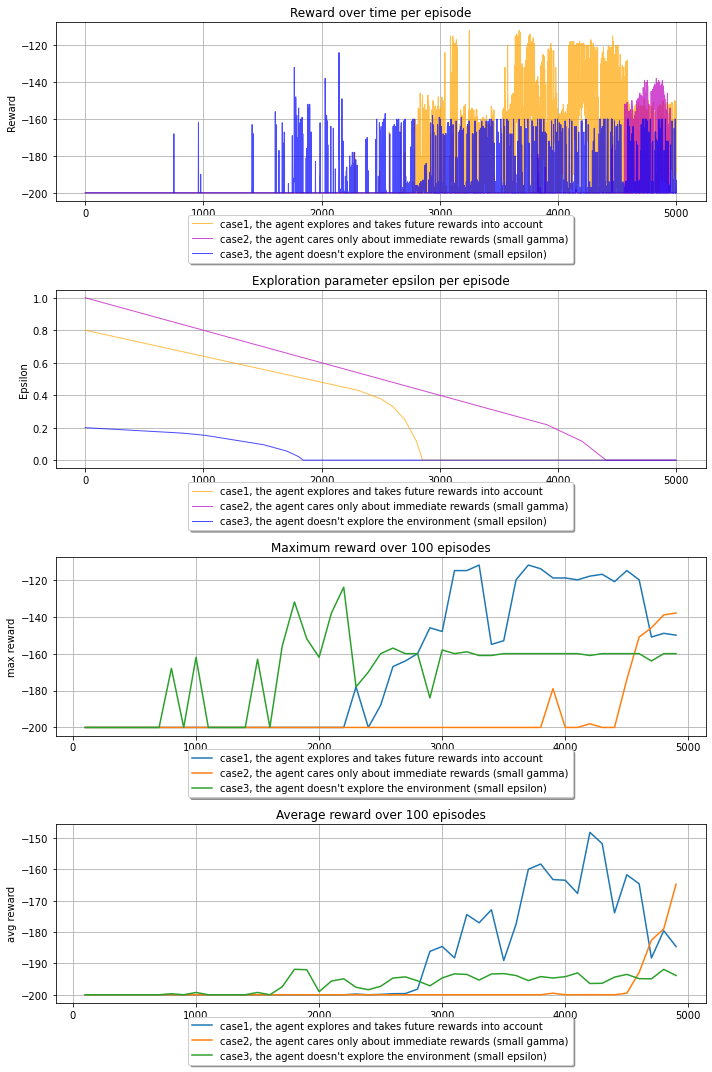

In [35]:
# visualize the different set of parameters
visualize_episodes(q_agent_1, q_agent_2, q_agent_3)

In [5]:
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
import numpy as np

In [6]:
# define the class which implements the Deep Q-learning algorithm
class DeepQAgent:


    def __init__(self, env,name, state_size,action_size,batch_size,learning_parameters, exploration_parameters):
        
        self.env = env
        self.name = name
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        
        # learning parameters
        self.learning_rate = learning_parameters['learning_rate']
        self.gamma = learning_parameters['gamma']
        
        # exploration parameters
        self.epsilon = exploration_parameters['epsilon']      
        self.min_epsilon = exploration_parameters['min_epsilon'] 
        self.epsilon_decay=exploration_parameters['epsilon_decay'] 
        
        #Our memory which we will use 
        self.memory = deque(maxlen=10000)
        self.model = self.build_model()

        #We build our model that once trained will get the optimal action from any state
        #To do that we use a neural network which takes the state as input
    def build_model(self):

        model = Sequential()
        model.add(Dense(24, input_shape=(self.state_size,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

        #We keep the information of every states in memory
    def remember(self, state, action, reward, new_state, done):
        self.memory.append((state, action, reward, new_state, done))

        #Choose the action with the highest activation from our models prediction for a given state
    def get_action(self, state):
        if np.random.random() < 1 - self.epsilon:
                action = self.model.predict(state)
                action=np.argmax(action[0])
        else:
                action = np.random.randint(0, self.env.action_space.n)
        return action 
        
        #We readjust the model using a batch of a fixed size take from our memory
    def replay(self):

        if len(self.memory) < self.batch_size:
            return
    
        #We select batch_size random samples from our memory
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        new_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        new_states = np.squeeze(new_states)
        
        #We calculate the targeted rewards taking in account whether the new_states are termination
        #states or not
        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(new_states), axis=1))*(1-dones)
        #We then calculate the predicted activations for each actions with respect to the states from
        #our minibatch
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        #We insert the values in tagets_full
        targets_full[[ind], [actions]] = targets
        #We update the activations and biases of our neural network to fit our minibatch
        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
        
        
    def train(self,total_episodes=200):
        self.scores = []
        for e in range(total_episodes):
            state = self.env.reset()
            state = np.reshape(state, (1, 2))
            #The score is the number of steps it takes to reach the flag score=200 ==> failure
            score = 0
            max_steps = 200
            for i in range(max_steps):
                #perform the most optimal action at this time
                action = self.get_action(state)
                new_state, reward, done, _ = self.env.step(action)
                new_state = np.reshape(new_state, (1, 2))
                #We took one more step
                score=score+1
                #Our reward here is choosen as the variation in mechanical energy of the car(kinetic+potential)
                #We want to make it learn to go faster(kinetic energy) and higher(potential energy)
                reward = 100*((math.sin(3*new_state[0,0]) * 0.0025 + 0.5 * new_state[0,1] * new_state[0,1])- (math.sin(3*state[0,0]) * 0.0025 + 0.5 * state[0,1] * state[0,1]))
                self.remember(state, action, reward, new_state, done)
                state = new_state
                self.replay()
                if done:
                    print("episode: {}/{}, score: {}".format(e, total_episodes, score))
                    #We do seeded runs to facilitate the learning
                    break
            self.scores.append(score)

In [7]:
env = gym.make('MountainCar-v0')
# Set the Training parameters
# Set number of stepts an agent can take, before the environment is reset, 
max_steps = 200
# Set total of training episodes (the number of trials a agent can do)    
total_episodes =20

#Size of our batches for the replay function
batch_size=64
## case1
name = 'case1, the agent explores and takes future rewards into account'

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.001,
    'gamma': 0.9} # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'min_epsilon': 0.005,
    'epsilon_decay': 0.995 }

dq_agent_1 = DeepQAgent(env, name, env.observation_space.shape[0], action_size,batch_size, learning_parameters, exploration_parameters)
dq_agent_1.train(total_episodes = total_episodes)

episode: 0/20, score: 200
episode: 1/20, score: 200
episode: 2/20, score: 200
episode: 3/20, score: 194
episode: 4/20, score: 176
episode: 5/20, score: 165
episode: 6/20, score: 154
episode: 7/20, score: 177
episode: 8/20, score: 165
episode: 9/20, score: 179
episode: 10/20, score: 144
episode: 11/20, score: 189
episode: 12/20, score: 181
episode: 13/20, score: 200
episode: 14/20, score: 179
episode: 15/20, score: 179
episode: 16/20, score: 146
episode: 17/20, score: 180
episode: 18/20, score: 156
episode: 19/20, score: 161


In [8]:
# Set the Training parameters
# Set number of stepts an agent can take, before the environment is reset, 
max_steps = 200
# Set total of training episodes (the number of trials a agent can do)    
total_episodes =20

#Size of our batches for the replay function
batch_size=64
### case2
name = 'case2, the agent cares only about immediate rewards (small gamma)'

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.001,
    'gamma': 0.5} # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'min_epsilon': 0,
    'epsilon_decay': 0.995 }

dq_agent_2 = DeepQAgent(env, name, env.observation_space.shape[0], action_size,batch_size, learning_parameters, exploration_parameters)
dq_agent_2.train(total_episodes = total_episodes)

episode: 0/20, score: 200
episode: 1/20, score: 200
episode: 2/20, score: 200
episode: 3/20, score: 200
episode: 4/20, score: 200
episode: 5/20, score: 149
episode: 6/20, score: 163
episode: 7/20, score: 172
episode: 8/20, score: 161
episode: 9/20, score: 181
episode: 10/20, score: 154
episode: 11/20, score: 176
episode: 12/20, score: 157
episode: 13/20, score: 165
episode: 14/20, score: 179
episode: 15/20, score: 169
episode: 16/20, score: 165
episode: 17/20, score: 197
episode: 18/20, score: 167
episode: 19/20, score: 168


In [9]:
# Set the Training parameters
# Set number of stepts an agent can take, before the environment is reset, 
max_steps = 200
# Set total of training episodes (the number of trials a agent can do)    
total_episodes =20

#Size of our batches for the replay function
batch_size=64
### case3
name = "case3, the agent doesn't explore the environment (small epsilon)"

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.001,
    'gamma': 1 } # gamma = 1, we care about all future rewards equally as the current one  
                  # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 0.2,
    'min_epsilon': 0,
    'epsilon_decay': 0.995 }

dq_agent_3 = DeepQAgent(env, name, env.observation_space.shape[0], action_size,batch_size, learning_parameters, exploration_parameters)
dq_agent_3.train(total_episodes = total_episodes)

episode: 0/20, score: 200
episode: 1/20, score: 200
episode: 2/20, score: 191
episode: 3/20, score: 183
episode: 4/20, score: 200
episode: 5/20, score: 200
episode: 6/20, score: 200
episode: 7/20, score: 200
episode: 8/20, score: 200
episode: 9/20, score: 200
episode: 10/20, score: 200
episode: 11/20, score: 200
episode: 12/20, score: 200
episode: 13/20, score: 200
episode: 14/20, score: 200
episode: 15/20, score: 200
episode: 16/20, score: 200
episode: 17/20, score: 200
episode: 18/20, score: 200
episode: 19/20, score: 200


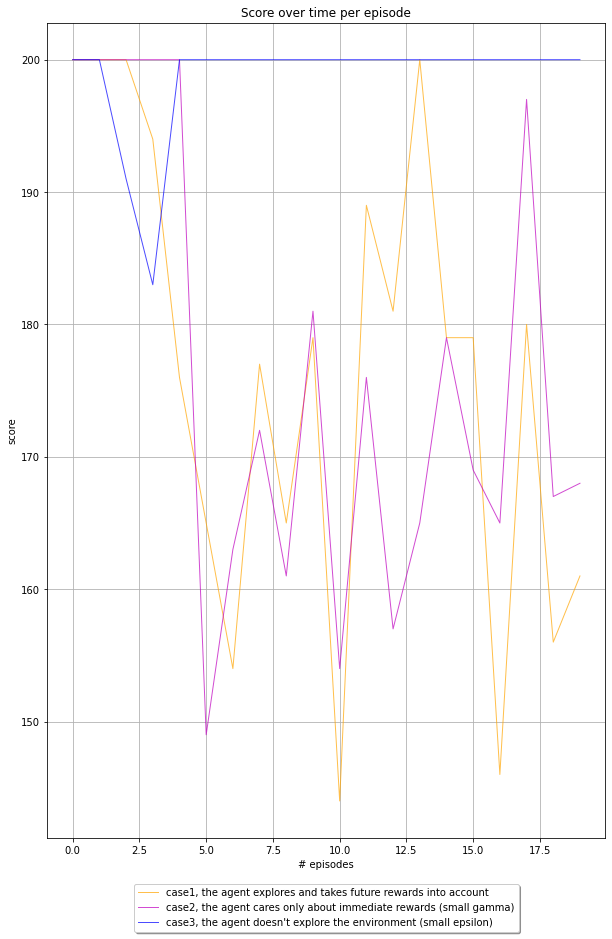

In [10]:
def deepq_visualize_episodes(*cases):

    plt.figure(figsize=(10,15))
    colour = ['orange', 'm','b','k','g']
    
    plt.plot()
    plt.title('Score over time per episode')
    for i, case in enumerate(cases):
        plt.plot(case.scores, c = colour[i], label = case.name, 
                 linewidth = 1, linestyle = '-', alpha = 0.7)
    plt.xlabel('# episodes')
    plt.ylabel('score')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)

    plt.show()
    
deepq_visualize_episodes(dq_agent_1, dq_agent_2, dq_agent_3)